In [1]:
%load_ext autoreload
%autoreload 2
import sys

import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from karateclub.graph_embedding.graph2vec import Graph2Vec
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

sys.path.append("../")
from src.graph2vec import Ensemble_G2V, OurGraph2Vec
from src.utils import *

plt.rcParams["figure.figsize"] = (16, 40)

In [3]:
graphs, labels = read_stargazers_dataset("../datasets/github_stargazers")

order_dict = np.load("../datasets/github_stargazers/orderings.npy", allow_pickle=True)[
    ()
]

Loaded 12725 graphs


## Parameters section

In [4]:
subset_card = len(graphs)  # number of graphs

cross_val_k = (
    26  # number of folds to perform in cross-validation (could be int or LeaveOneOut())
)

In [5]:
MEASURES = ["closeness_centrality", "pagerank", "current_flow_closeness_centrality"]

tested_range = np.linspace(0, 1, 11)

WEIGHTING_FUNCTIONS = (
    {f"w_mean_{a:.2f}": weighted_mean(a) for a in tested_range}
    | {f"w_var_{a:.2f}": by_weighted_variance(a) for a in tested_range}
    | {f"concat": lambda x, y: np.concatenate((x, y), axis=1)}
    | {
        f"proj_on_{a,b}": one_by_projection(a, b)
        for a, b in [(True, True), (True, False), (False, True), (False, False)]
    }
    | {f"proj_and_diff": projection_diff()}
    | {f"w_proj_{a:.2f}": weighted_projections(a) for a in tested_range}
)

### Execution section

In [6]:
graphs_subset = graphs[:subset_card]

without = OurGraph2Vec()
with_dm = OurGraph2Vec(cbowlike=True)
ens_model = Ensemble_G2V(without, with_dm)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

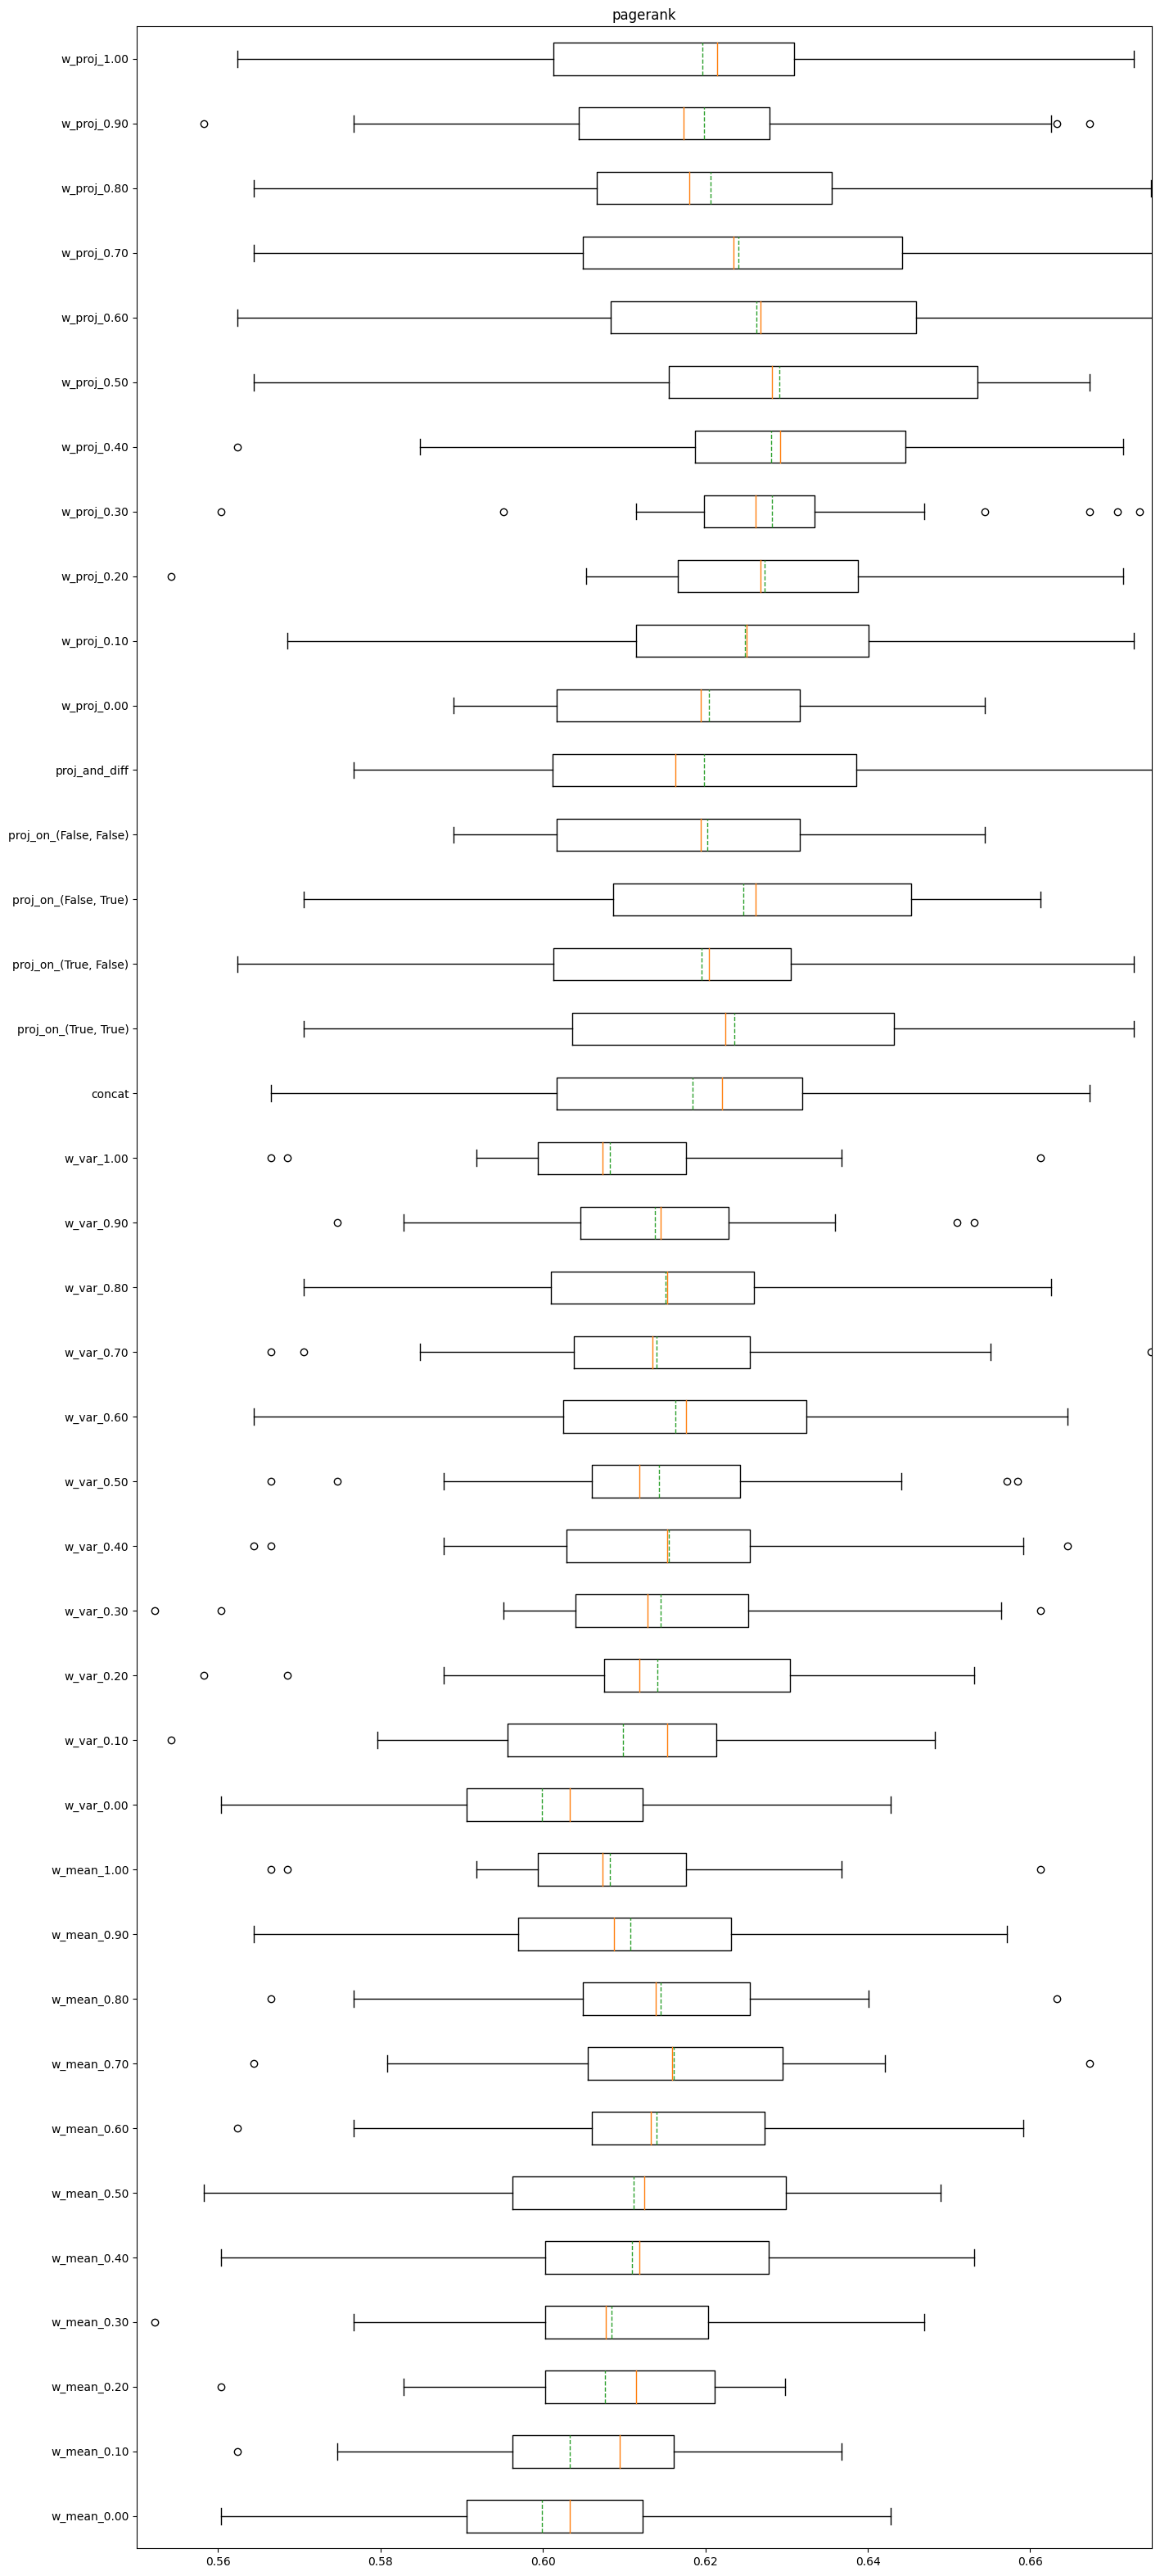

  0%|          | 0/39 [00:00<?, ?it/s]

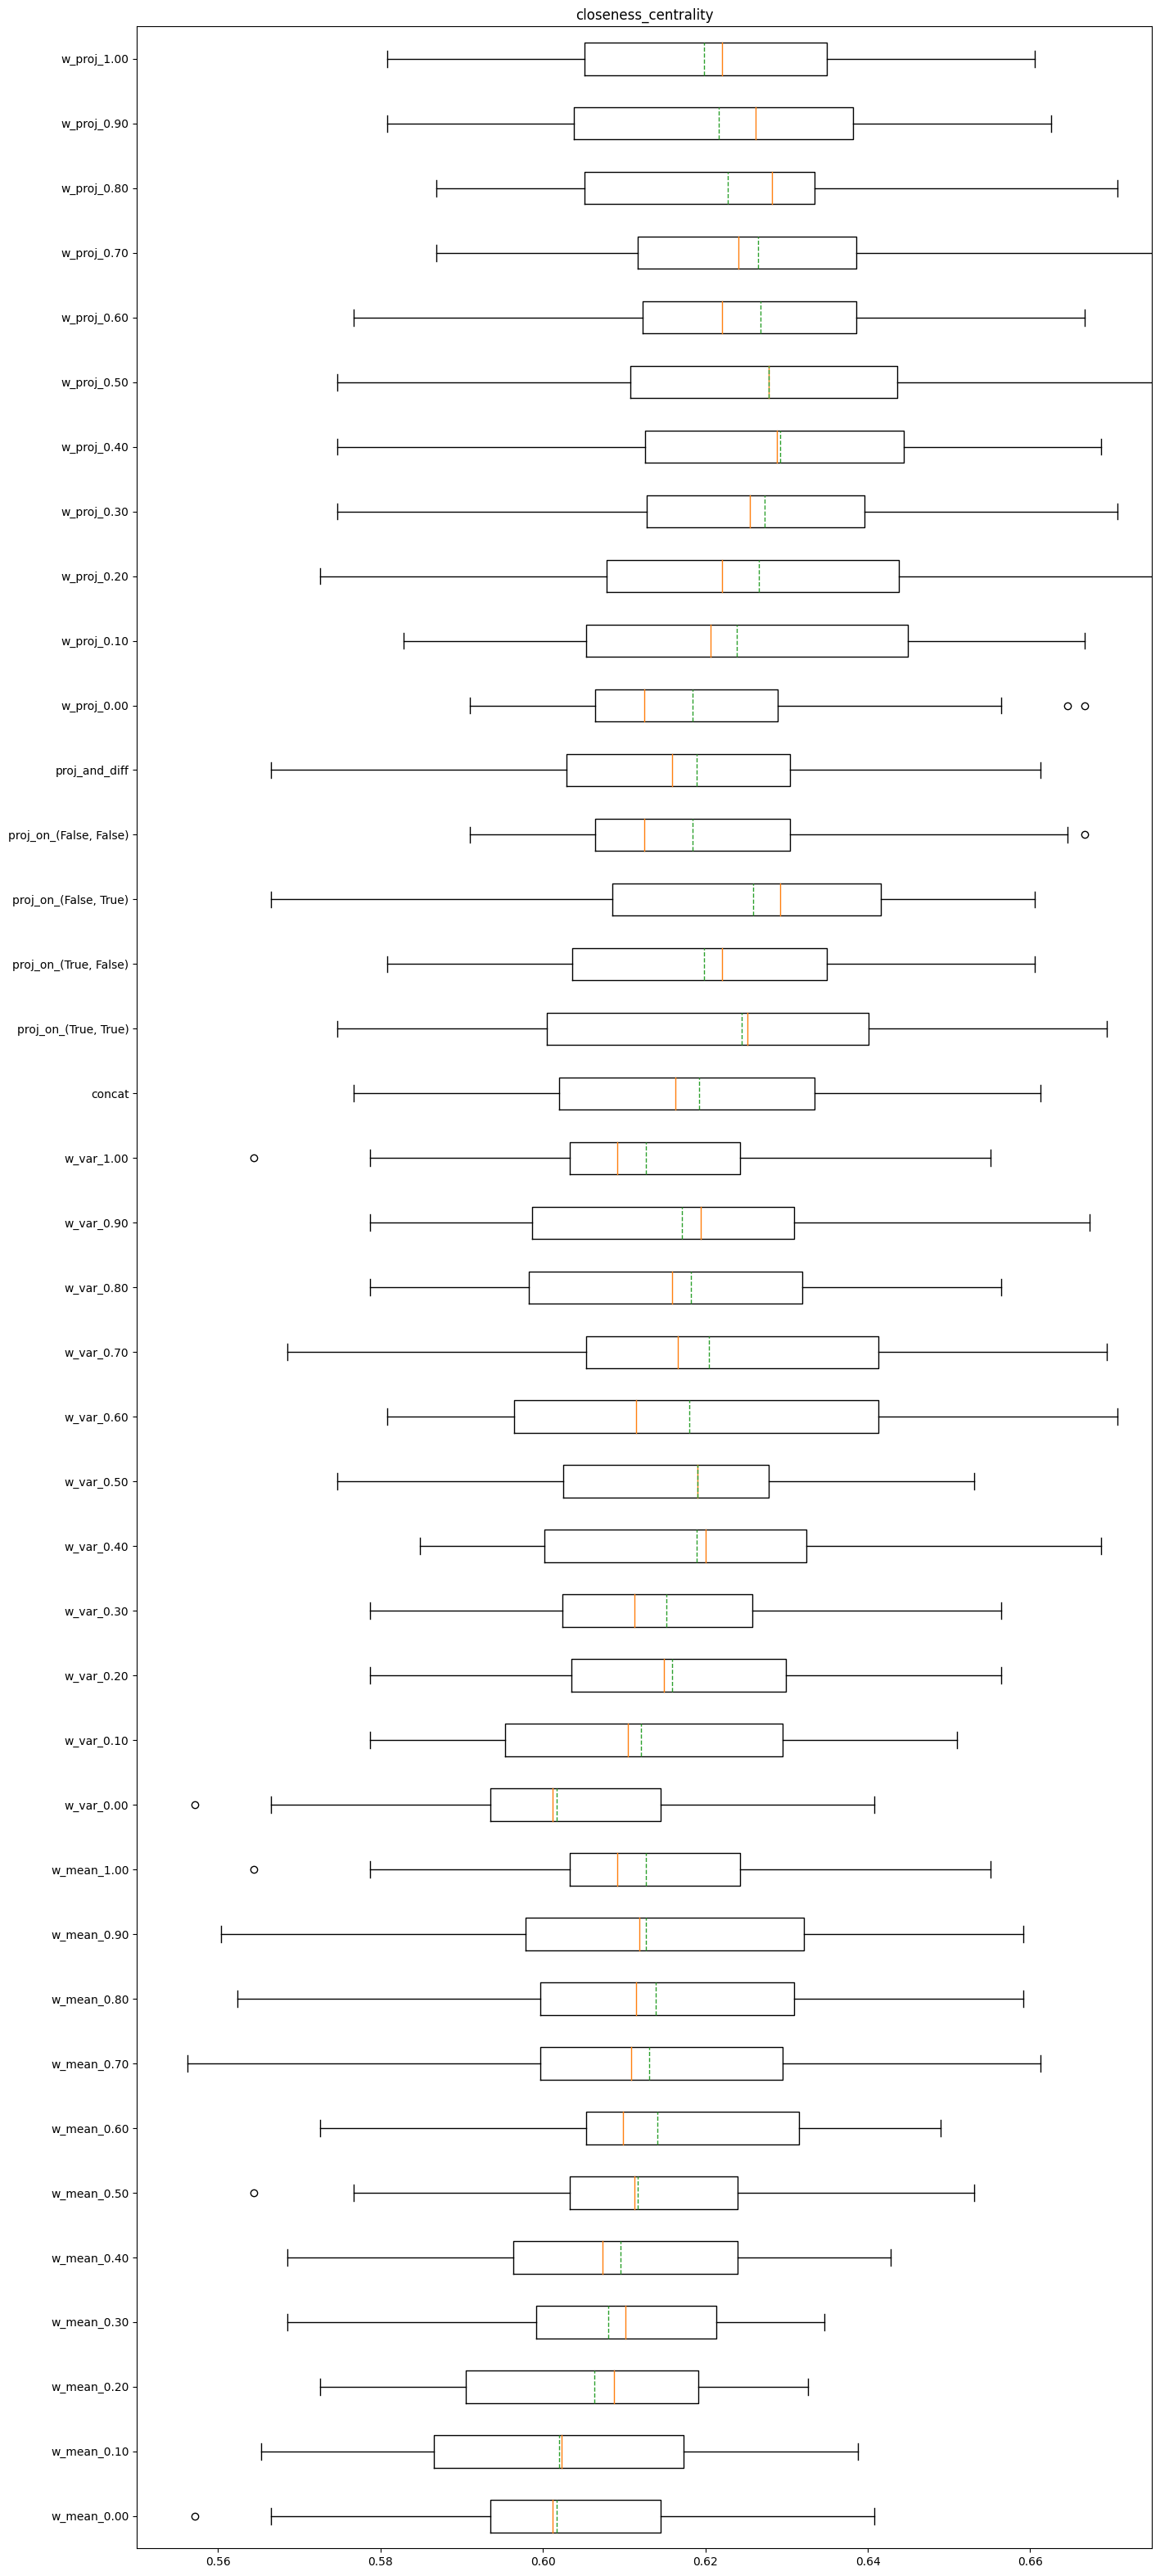

  0%|          | 0/39 [00:00<?, ?it/s]

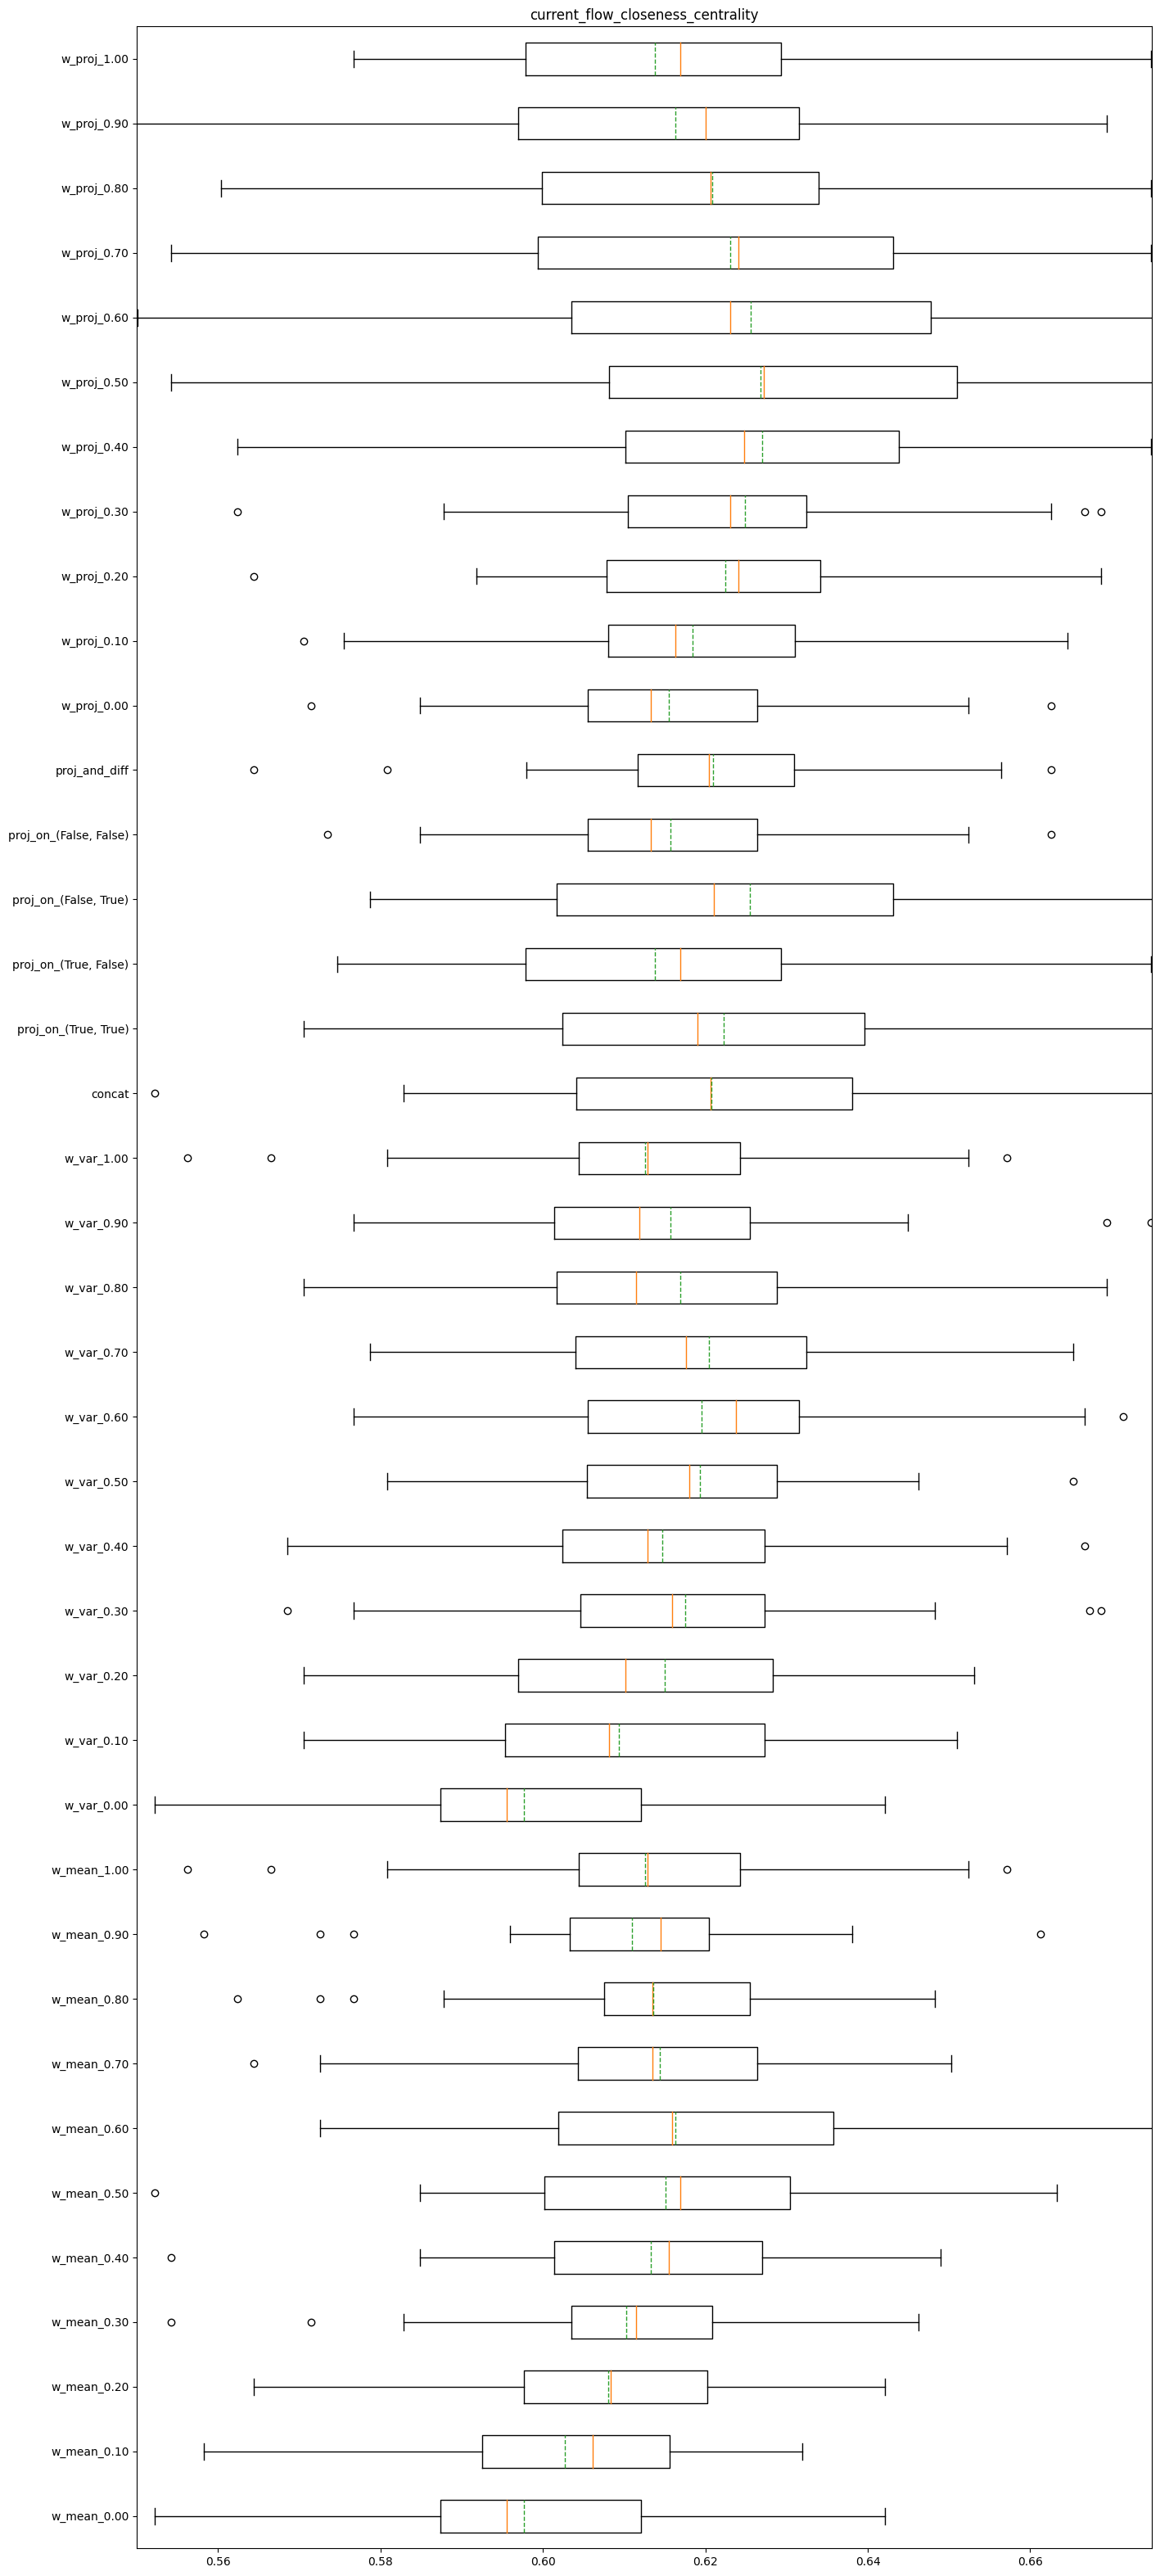

In [7]:
for measure, order in tqdm(order_dict.items()):
    res = {}
    without.fit(graphs_subset, orderings=order)
    with_dm.fit(graphs_subset, orderings=order)
    for name, func in tqdm(WEIGHTING_FUNCTIONS.items(), leave=False):
        ens_model.set_weighting_function(func)
        res[name] = cross_validate(
            ens_model.get_embedding(),
            labels,
            LogisticRegression(max_iter=1000),
            cv=cross_val_k,
        )
    n_items = len(res)
    plt.title(measure)
    plt.boxplot(
        res.values(),
        positions=range(n_items),
        vert=False,
        showmeans=True,
        meanline=True,
    )
    plt.yticks(range(n_items), labels=res.keys())
    plt.xlim([0.55, 0.675])
    plt.show()